# Stroke Prediction

## Importing libraries

In [42]:
import os
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Creating data frame 

In [7]:
print('Current project directory:', os.getcwd())

Current project directory: /home/pearlruby/Project/Stroke Prediction


In [8]:
file_path = 'healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file_path)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [9]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.00,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.10,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.00,0.00,77.25,23.50,0.00
50%,36932.00,45.00,0.00,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.00,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.00,1.00,271.74,97.60,1.00


**Elucidate:**

The last column "stroke" is the response column whereas rest of the columns are predictors. They are independent to each other but response column can be dependent on the predictors. 0 and 1 represent whether a patient had stroke or not, specifically 0 represents no stroke and represents yes stroke.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- The shape of the data set before pre-processing is 5110 rows * 12 columns.
- Column index represents the response and the rest represent predictors
- There are 5 categorical features and the rest are numerical ones
- All the columns have either values (numerical/categorical) or null replacers such as 'NaN', '', etc.. We are unable to confirm that the dataset doesn't contain any missing values.
- Visually, we see that predictor "bmi" has 201 not applicable values. Since the number is a way lesser than 30% of the total, we delete the respective rows.

In [12]:
print('Feature column names:', df.loc[:, df.columns != 'stroke'].columns)

print('\nTarget column labels:', df['stroke'].unique())

Feature column names: Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

Target column labels: [1 0]


In [13]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [14]:
df = df.dropna()
#df = df.reset_index()
print('New shape:', df.shape)

New shape: (4909, 12)


* The missing values are dropped and then the dataframe is reindex.

## Data pre-processing

### Outlier detection and handling

<AxesSubplot:>

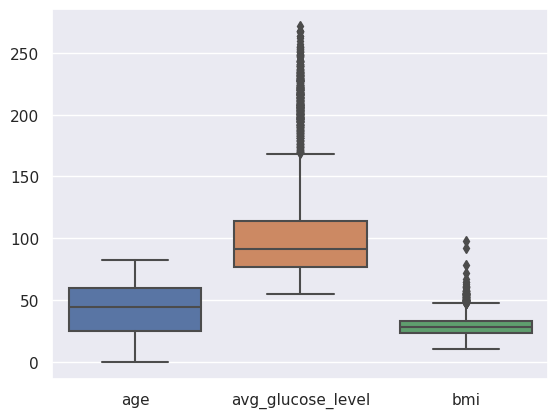

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

sns.boxplot(data = df[['age', 'avg_glucose_level', 'bmi']], orient = 'v')

* With a simple box plot, one can detect outliers.
* An outlier really affects a model performance, so most common method of handing it is to remove it.
* We are doing box plots for there columns such as "age", "avg_glucose_level", and "bmi". Visually we conclude that column age doesn't have an outlier but columns avg_glucose_level and bmi have many outliers which need to handled before fitting the data with a model 

In [16]:
# define the lower and upper bounds for outliers
q1 = df['avg_glucose_level'].quantile(0.25)
q3 = df['avg_glucose_level'].quantile(0.75)

iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

df = df[(df['avg_glucose_level'] >= lower_bound) & (df['avg_glucose_level'] <= upper_bound)]
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
6,53882,Male,74.00,1,1,Yes,Private,Rural,70.09,27.40,never smoked,1
7,10434,Female,69.00,0,0,No,Private,Urban,94.39,22.80,never smoked,1
9,60491,Female,78.00,0,0,Yes,Private,Urban,58.57,24.20,Unknown,1
10,12109,Female,81.00,1,0,Yes,Private,Rural,80.43,29.70,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.00,0,0,No,children,Rural,103.08,18.60,Unknown,0
5106,44873,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0
5107,19723,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0
5108,37544,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0


568 rows are filter based on the outlier detection criteria as these data points are placed not within the lower bound and upper bound.

In [17]:
# define the lower and upper bounds for outliers
q1 = df['bmi'].quantile(0.25)
q3 = df['bmi'].quantile(0.75)

iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

df = df[(df['bmi'] >= lower_bound) & (df['bmi'] <= upper_bound)]
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
6,53882,Male,74.00,1,1,Yes,Private,Rural,70.09,27.40,never smoked,1
7,10434,Female,69.00,0,0,No,Private,Urban,94.39,22.80,never smoked,1
9,60491,Female,78.00,0,0,Yes,Private,Urban,58.57,24.20,Unknown,1
10,12109,Female,81.00,1,0,Yes,Private,Rural,80.43,29.70,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,13.00,0,0,No,children,Rural,103.08,18.60,Unknown,0
5106,44873,Female,81.00,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0
5107,19723,Female,35.00,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0
5108,37544,Male,51.00,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0


90 rows were removed as soon as we knew that they were outliers. The number is approximately 6.3 times smaller tha the rows of average level of gluscose column.

In [21]:
df = df.drop(['id'], axis = 1)

In [23]:
duplicate_rows = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows.shape)

number of duplicate rows:  (0, 11)


<AxesSubplot:xlabel='work_type', ylabel='Count'>

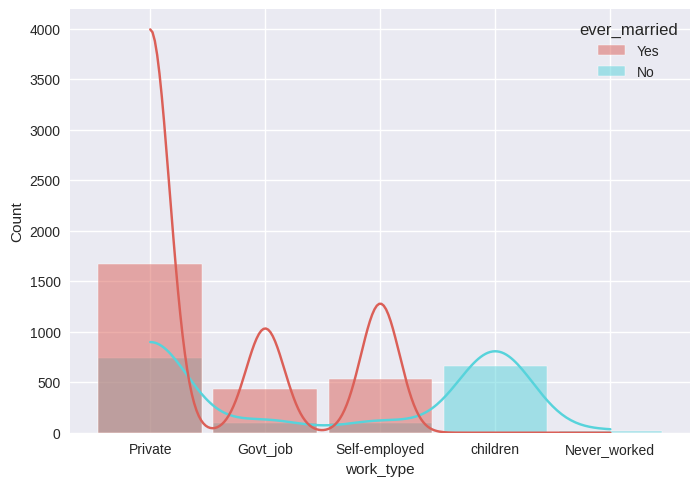

In [24]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2)
color = 'winter'

sns.histplot(data = df, kde=True, palette = 'hls',  x = 'work_type', hue = 'ever_married', shrink = .9)

* More than 1600 people who were not bachelor and employed privately had stroke. Around 750 bachelor people who worksed private had stroke.
* Greater than 450 people who were not bachelor and have Government jobs has stroke. More than 100 people who were bachelors had stroke.
* More than 500 people who were self employeed and married had stroke. Greater than 100 people who were never married had stroke. 
* From all the above observations, we can clearly note that married people with atleast 1 stroke in their medical history is twice as the bachelor people.  
* There was 0 case under married childern catergory. It is now evident that child marriage is not happening in the population. 
* People who never worked didn't have stroke attack. We see that people never worked will not have stroke. 
* People in private job type has a huge number of stroke cases when campared to Government job and self-employed people. 

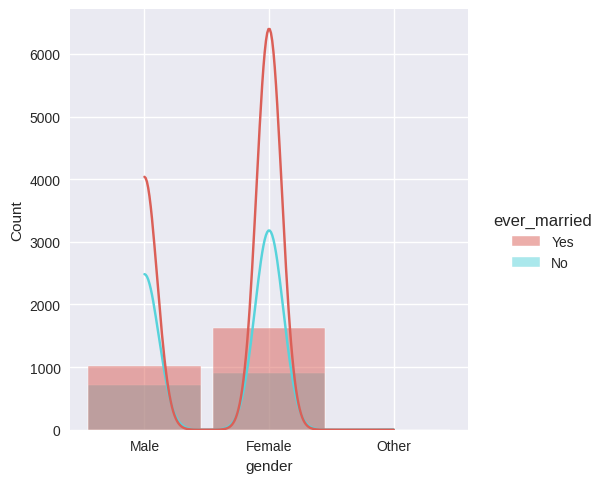

In [25]:
sns.displot(df, x = 'gender', kde=True, palette = 'hls', hue = 'ever_married', shrink = .9)

* The density of females who are married have high chances of getting a stroke because in this sample married females had stroke with significantly larger value than married male. 

* The density of female bachelors has 600 to 700 strokes more than male bachelors.

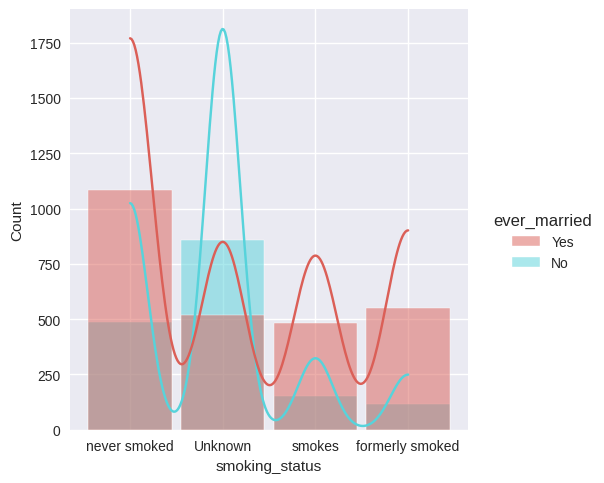

In [26]:
sns.displot(df, x = 'smoking_status', kde=True, palette = 'hls', hue = 'ever_married', shrink = .9)
plt.show()

* Surprisingly, the group of people who regularly smoked had less number of stroke. Among them, bachelors were less than 40% of the total people.
* Contradictoryly, married people who never smoked had srokes higher in number than all of smoking status. Among them, again bachelors were less than 45% of the total people.
* We easily conclude based on the sample that person who doesn't smoke may have stroke with high chances than who smokes.

In [27]:
le = preprocessing.LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['Residence_type'] = le.fit_transform(df['Residence_type'])
df['work_type'] = le.fit_transform(df['work_type'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

##### Label encoding: 
Columns such as gender, ever_married, residence_type, work_type, and smoking status are categorical by default. In order to put use them in prediction, they have to undergo label encoding transformation.

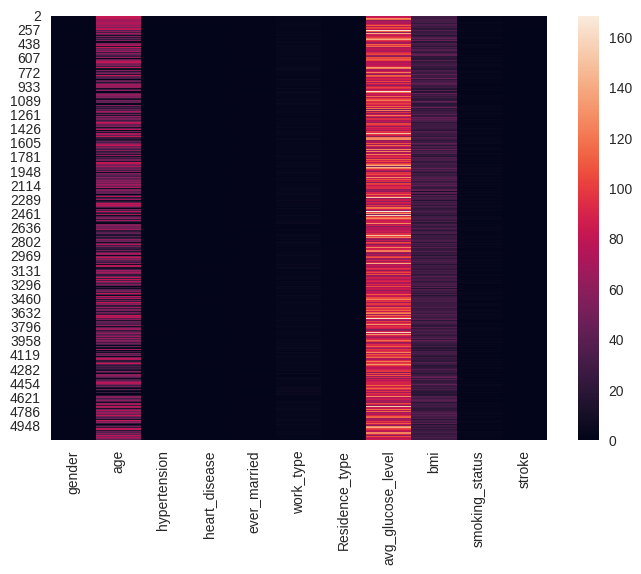

In [28]:
sns.heatmap(df)
plt.show()

The above heatmap plot shows columns that have high variances. Columns age, average_glucose_level, and bmi have high variances. Hence they are visually appearable.

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,1.00,-0.05,0.02,0.09,-0.05,0.07,-0.00,0.03,-0.00,-0.06,-0.00
age,-0.05,1.00,0.25,0.24,0.69,-0.40,0.01,-0.03,0.38,0.30,0.21
hypertension,0.02,0.25,1.00,0.11,0.15,-0.06,-0.00,-0.00,0.15,0.12,0.12
heart_disease,0.09,0.24,0.11,1.00,0.11,-0.03,-0.01,0.01,0.06,0.06,0.09
ever_married,-0.05,0.69,0.15,0.11,1.00,-0.38,0.00,-0.01,0.38,0.28,0.09
work_type,0.07,-0.40,-0.06,-0.03,-0.38,1.00,-0.00,0.02,-0.36,-0.34,-0.03
Residence_type,-0.00,0.01,-0.00,-0.01,0.00,-0.00,1.00,-0.02,0.01,0.02,0.00
avg_glucose_level,0.03,-0.03,-0.00,0.01,-0.01,0.02,-0.02,1.00,0.00,-0.00,0.01
bmi,-0.00,0.38,0.15,0.06,0.38,-0.36,0.01,0.00,1.00,0.27,0.03
smoking_status,-0.06,0.30,0.12,0.06,0.28,-0.34,0.02,-0.00,0.27,1.00,0.04


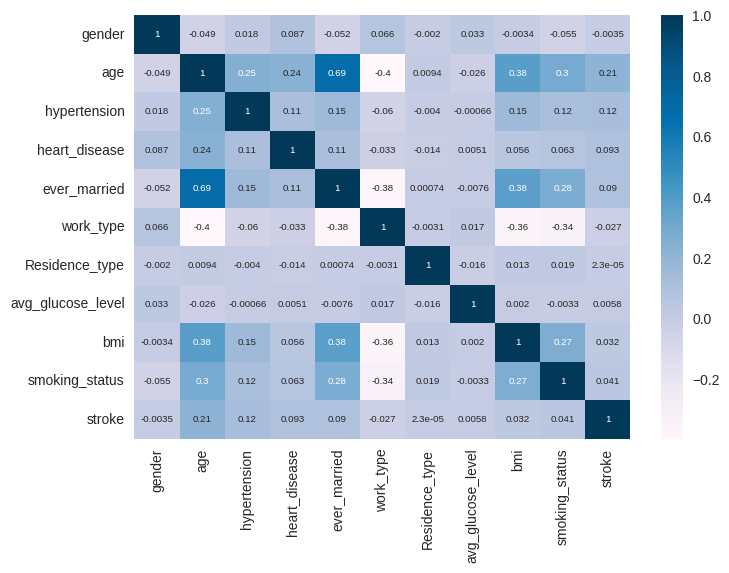

In [29]:
corr = df.corr()
sns.heatmap(corr, cmap= "PuBu", annot = True, annot_kws={'size': 7})
corr

This correlation map shows degree of similarity and relationship between all the features. Variables ever_married and age have the highest correlation cofficient as 0.69. Variables stroke and residence_type have the least correlation coefficient value as 0.000023.

In [30]:
scale = StandardScaler()

variables = df[['age', 'avg_glucose_level', 'bmi']]
scaled_variables = scale.fit_transform(variables)

df['age'] = scaled_variables[:, 0]
df['avg_glucose_level'] = scaled_variables[:, 1]
df['bmi'] = scaled_variables[:, 2]

## Prediction with classifiers

In [35]:
y, X = df['stroke'], df.drop('stroke', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [36]:
classifier = LazyClassifier(verbose = 0, ignore_warnings = True, custom_metric = None)
models, predictions = classifier.fit(X_train, X_test, y_train, y_test)

print(models)

100%|███████████████████████████████████████████████| 29/29 [00:05<00:00,  5.70it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.74               0.76     0.76      0.82   
GaussianNB                         0.89               0.63     0.63      0.92   
QuadraticDiscriminantAnalysis      0.89               0.63     0.63      0.92   
PassiveAggressiveClassifier        0.89               0.62     0.62      0.92   
ExtraTreeClassifier                0.93               0.53     0.53      0.94   
LabelPropagation                   0.95               0.53     0.53      0.95   
LabelSpreading                     0.95               0.53     0.53      0.95   
LinearDiscriminantAnalysis         0.97               0.52     0.52      0.95   
LGBMClassifier                     0.96               0.52     0.52      0.95   
XGBClassifier                      0.96               0.52     0.52      0.95   
KNeighborsClassifier        

Here we see that XGBClassifier performs quite good in all the performance metrics incluidng F1 score. So we take it as an ideal classifier for the classification task.

In [37]:
ros = RandomOverSampler(sampling_strategy = 0.5)
X_resampled, y_resampled = ros.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3)

X_resampled.to_csv('X_resampled.csv')
y_resampled.to_csv('y_resampled.csv')

In [38]:
model = xgb.XGBClassifier(n_estimators = 20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:", '\n')
print(conf_matrix)

Accuracy: 0.9444144630329195
Precision: 0.8797736916548797
Recall: 0.971875
F1-Score: 0.9235337787676318
Confusion Matrix: 

[[1128   85]
 [  18  622]]


# END 